# Filmaffinity

In [1]:
import requests
from bs4 import BeautifulSoup

## Links mejores pelis

In [ ]:
# Parámetros para la URL (puedes cambiar estos valores dinámicamente)
params = {
    "releaseYearMin": 2015,  # Año mínimo
    "releaseYearMax": 2020,  # Año máximo
    "page": 1                # Número de página
}

n = 24  # Número de películas que queremos obtener

# URL base
url = "https://www.metacritic.com/browse/movie/"

# Realizamos la solicitud GET con los parámetros
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36"
}
response = requests.get(url, headers=headers, params=params)

# Comprobamos si la solicitud fue exitosa
if response.status_code == 200:
    soup = BeautifulSoup(response.content, "html.parser")
    
    # Encontramos todos los enlaces a las películas
    movie_links_positive = soup.find_all("a", class_="c-finderProductCard_container g-color-gray80 u-grid")
    
    # Lista para almacenar los enlaces
    links_positive = []

    # Extraemos los enlaces de las primeras 24 películas y los guardamos en la lista
    for idx, link in enumerate(movie_links_positive[:n]):  # Solo las primeras 24
        href = link.get("href")
        if href:
            full_url = f"https://www.metacritic.com{href}"
            links_positive.append(full_url)  # Guardamos el enlace en la lista
            print(f"Película {idx+1}: {full_url}")
    
    # Opcional: Puedes ver todos los enlaces almacenados
    print("\nLista de enlaces almacenados:")
    print(links_positive)

else:
    print("Error al acceder a la página.")

Película 1: https://www.metacritic.com/movie/moonlight-2016/
Película 2: https://www.metacritic.com/movie/parasite/
Película 3: https://www.metacritic.com/movie/roma/
Película 4: https://www.metacritic.com/movie/manchester-by-the-sea/
Película 5: https://www.metacritic.com/movie/small-axe-lovers-rock/
Película 6: https://www.metacritic.com/movie/portrait-of-a-lady-on-fire/
Película 7: https://www.metacritic.com/movie/i-am-not-your-negro/
Película 8: https://www.metacritic.com/movie/collective/
Película 9: https://www.metacritic.com/movie/carol/
Película 10: https://www.metacritic.com/movie/amazing-grace-1972/
Película 11: https://www.metacritic.com/movie/dunkirk/
Película 12: https://www.metacritic.com/movie/45-years/
Película 13: https://www.metacritic.com/movie/the-irishman/
Película 14: https://www.metacritic.com/movie/inside-out-2015/
Película 15: https://www.metacritic.com/movie/faces-places/
Película 16: https://www.metacritic.com/movie/call-me-by-your-name/
Película 17: https://

## Links peores pelis

In [ ]:
# Parámetros para la URL (puedes cambiar estos valores dinámicamente)
params = {
    "releaseYearMin": 2015,  # Año mínimo
    "releaseYearMax": 2020,  # Año máximo
    "page": 149                # Número de página
}

# URL base
url = "https://www.metacritic.com/browse/movie/"

# Realizamos la solicitud GET con los parámetros
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36"
}
response = requests.get(url, headers=headers, params=params)

# Comprobamos si la solicitud fue exitosa
if response.status_code == 200:
    soup = BeautifulSoup(response.content, "html.parser")
    
    # Encontramos todos los enlaces a las películas
    movie_links_worst = soup.find_all("a", class_="c-finderProductCard_container g-color-gray80 u-grid")
    
    # Lista para almacenar los enlaces
    links_worst = []

    # Extraemos los enlaces de las primeras 24 películas y los guardamos en la lista
    for idx, link in enumerate(movie_links_worst[:n]):  # Solo las primeras 24
        href = link.get("href")
        if href:
            full_url = f"https://www.metacritic.com{href}"
            links_worst.append(full_url)  # Guardamos el enlace en la lista
            print(f"Película {idx+1}: {full_url}")
    
    # Opcional: Puedes ver todos los enlaces almacenados
    print("\nLista de enlaces almacenados:")
    print(links_worst)

else:
    print("Error al acceder a la página.")

Película 1: https://www.metacritic.com/movie/search-party/
Película 2: https://www.metacritic.com/movie/max-steel/
Película 3: https://www.metacritic.com/movie/enter-the-dangerous-mind/
Película 4: https://www.metacritic.com/movie/home-sweet-hell/
Película 5: https://www.metacritic.com/movie/martyrs/
Película 6: https://www.metacritic.com/movie/the-tax-collector/
Película 7: https://www.metacritic.com/movie/gods-not-dead-2/
Película 8: https://www.metacritic.com/movie/blumhouses-fantasy-island/
Película 9: https://www.metacritic.com/movie/norm-of-the-north/
Película 10: https://www.metacritic.com/movie/a-family-man/
Película 11: https://www.metacritic.com/movie/geostorm/
Película 12: https://www.metacritic.com/movie/dirty-grandpa/
Película 13: https://www.metacritic.com/movie/211/
Película 14: https://www.metacritic.com/movie/the-clapper/
Película 15: https://www.metacritic.com/movie/just-getting-started/
Película 16: https://www.metacritic.com/movie/life-itself-2018/
Película 17: http

## Links pelis neutras

In [ ]:
# Parámetros para la URL (puedes cambiar estos valores dinámicamente)
params = {
    "releaseYearMin": 2015,  # Año mínimo
    "releaseYearMax": 2020,  # Año máximo
    "page": 90                # Número de página
}

# URL base
url = "https://www.metacritic.com/browse/movie/"

# Realizamos la solicitud GET con los parámetros
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36"
}
response = requests.get(url, headers=headers, params=params)

# Comprobamos si la solicitud fue exitosa
if response.status_code == 200:
    soup = BeautifulSoup(response.content, "html.parser")
    
    # Encontramos todos los enlaces a las películas
    movie_links_neutral = soup.find_all("a", class_="c-finderProductCard_container g-color-gray80 u-grid")
    
    # Lista para almacenar los enlaces
    links_neutral = []

    # Extraemos los enlaces de las primeras 24 películas y los guardamos en la lista
    for idx, link in enumerate(movie_links_neutral[:n]):  # Solo las primeras 24
        href = link.get("href")
        if href:
            full_url = f"https://www.metacritic.com{href}"
            links_neutral.append(full_url)  # Guardamos el enlace en la lista
            print(f"Película {idx+1}: {full_url}")
    
    # Opcional: Puedes ver todos los enlaces almacenados
    print("\nLista de enlaces almacenados:")
    print(links_neutral)

else:
    print("Error al acceder a la página.")

Película 1: https://www.metacritic.com/movie/i-smile-back/
Película 2: https://www.metacritic.com/movie/between-two-ferns-the-movie/
Película 3: https://www.metacritic.com/movie/all-is-true/
Película 4: https://www.metacritic.com/movie/champs/
Película 5: https://www.metacritic.com/movie/amnesia-2015/
Película 6: https://www.metacritic.com/movie/crooked-house/
Película 7: https://www.metacritic.com/movie/judy-punch/
Película 8: https://www.metacritic.com/movie/ottolenghi-and-the-cakes-of-versailles/
Película 9: https://www.metacritic.com/movie/doctor-sleep/
Película 10: https://www.metacritic.com/movie/the-boy-downstairs/
Película 11: https://www.metacritic.com/movie/the-rachel-divide/
Película 12: https://www.metacritic.com/movie/extraordinary-tales/
Película 13: https://www.metacritic.com/movie/sing/
Película 14: https://www.metacritic.com/movie/lizzie/
Película 15: https://www.metacritic.com/movie/the-lovebirds/
Película 16: https://www.metacritic.com/movie/on-the-basis-of-sex/
Pelí

## Link pelis neutras-buenas

In [6]:
# Parámetros para la URL (puedes cambiar estos valores dinámicamente)
params = {
    "releaseYearMin": 2015,  # Año mínimo
    "releaseYearMax": 2020,  # Año máximo
    "page": 50                # Número de página
}

# URL base
url = "https://www.metacritic.com/browse/movie/"

# Realizamos la solicitud GET con los parámetros
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36"
}
response = requests.get(url, headers=headers, params=params)

# Comprobamos si la solicitud fue exitosa
if response.status_code == 200:
    soup = BeautifulSoup(response.content, "html.parser")
    
    # Encontramos todos los enlaces a las películas
    movie_links_others = soup.find_all("a", class_="c-finderProductCard_container g-color-gray80 u-grid")
    
    # Lista para almacenar los enlaces
    links_others = []

    # Extraemos los enlaces de las primeras 24 películas y los guardamos en la lista
    for idx, link in enumerate(movie_links_others[:n]):  # Solo las primeras 24
        href = link.get("href")
        if href:
            full_url = f"https://www.metacritic.com{href}"
            links_others.append(full_url)  # Guardamos el enlace en la lista
            print(f"Película {idx+1}: {full_url}")
    
    # Opcional: Puedes ver todos los enlaces almacenados
    print("\nLista de enlaces almacenados:")
    print(links_others)

else:
    print("Error al acceder a la página.")

Película 1: https://www.metacritic.com/movie/breath/
Película 2: https://www.metacritic.com/movie/the-woman-who-loves-giraffes/
Película 3: https://www.metacritic.com/movie/yes-god-yes/
Película 4: https://www.metacritic.com/movie/lucky-grandma/
Película 5: https://www.metacritic.com/movie/girls-trip/
Película 6: https://www.metacritic.com/movie/florence-foster-jenkins/
Película 7: https://www.metacritic.com/movie/the-farewell-party/
Película 8: https://www.metacritic.com/movie/francofonia/
Película 9: https://www.metacritic.com/movie/mavis!/
Película 10: https://www.metacritic.com/movie/dogman/
Película 11: https://www.metacritic.com/movie/cam/
Película 12: https://www.metacritic.com/movie/sweetheart/
Película 13: https://www.metacritic.com/movie/big-sonia/
Película 14: https://www.metacritic.com/movie/letters-from-baghdad/
Película 15: https://www.metacritic.com/movie/the-great-buster-a-celebration/
Película 16: https://www.metacritic.com/movie/tomorrow/
Película 17: https://www.meta

## URL Reseñas 

In [7]:
# Definir los filtros y las listas
filters = ['Positive%20Reviews', 'Mixed%20Reviews', 'Negative%20Reviews']
link_lists = [links_positive, links_neutral, links_worst, links_others]

# Lista para almacenar los enlaces
review_links = []

# Iterar sobre los filtros y las listas de enlaces
for filter_type in filters:
    for link_list in link_lists:
        review_links += [f"{url}user-reviews/?filter={filter_type}" for url in link_list]

# Ahora review_links contiene todas las URLs concatenadas
print(review_links)
print(f"Tamaño de review_links: {len(review_links)}")

['https://www.metacritic.com/movie/moonlight-2016/user-reviews/?filter=Positive%20Reviews', 'https://www.metacritic.com/movie/parasite/user-reviews/?filter=Positive%20Reviews', 'https://www.metacritic.com/movie/roma/user-reviews/?filter=Positive%20Reviews', 'https://www.metacritic.com/movie/manchester-by-the-sea/user-reviews/?filter=Positive%20Reviews', 'https://www.metacritic.com/movie/small-axe-lovers-rock/user-reviews/?filter=Positive%20Reviews', 'https://www.metacritic.com/movie/portrait-of-a-lady-on-fire/user-reviews/?filter=Positive%20Reviews', 'https://www.metacritic.com/movie/i-am-not-your-negro/user-reviews/?filter=Positive%20Reviews', 'https://www.metacritic.com/movie/collective/user-reviews/?filter=Positive%20Reviews', 'https://www.metacritic.com/movie/carol/user-reviews/?filter=Positive%20Reviews', 'https://www.metacritic.com/movie/amazing-grace-1972/user-reviews/?filter=Positive%20Reviews', 'https://www.metacritic.com/movie/dunkirk/user-reviews/?filter=Positive%20Reviews',

## Extracción de reseñas

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import time
import pandas as pd

def get_user_reviews_selenium(movie_url, max_pages=1):  # Cambié max_pages a 1 para limitar la cantidad de páginas
    chrome_options = Options()
    #chrome_options.add_argument("--headless")  # Ejecutar sin abrir ventana
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("user-agent=Mozilla/5.0")

    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)

    all_reviews = []

    for page in range(max_pages):  # Solo una página por URL
        url = f"{movie_url}&page={page + 1}"  # Se añade la página actual a la URL
        driver.get(url)
        time.sleep(2)  # Espera a que cargue JavaScript

        soup = BeautifulSoup(driver.page_source, "html.parser")

        review_containers = soup.find_all("div", attrs={"data-testid": "product-review"})

        for container in review_containers:
            score_tag = container.find("div", class_="c-siteReviewScore")
            score = score_tag.get_text(strip=True) if score_tag else "No score"

            user_tag = container.find("a", class_="c-siteReviewHeader_username")
            username = user_tag.get_text(strip=True) if user_tag else "No username"

            date_tag = container.find("div", class_="c-siteReviewHeader_reviewDate")
            date = date_tag.get_text(strip=True) if date_tag else "No date"

            quote_tag = container.find("div", class_="c-siteReview_quote")
            review_text = quote_tag.get_text(strip=True) if quote_tag else "No review text"

            all_reviews.append({
                "movie_url": movie_url,  # Añadimos la URL de la película
                "username": username,
                "date": date,
                "score": score,
                "review": review_text
            })

        if len(all_reviews) >= 10:  # Si ya tenemos 10 reseñas, salimos del bucle
            break

    driver.quit()
    return all_reviews


# Lista para almacenar todas las reseñas
all_reviews_data = []

# Extraer 10 reseñas para cada enlace en review_links
for movie_url in review_links:
    print(f"Extrayendo reseñas de: {movie_url}")
    reviews = get_user_reviews_selenium(movie_url)

    # Almacenar las reseñas en la lista
    for review in reviews[:10]:  # Almacenamos solo las primeras 10 reseñas
        all_reviews_data.append(review)

# Convertir la lista de reseñas a un DataFrame de pandas
df_reviews = pd.DataFrame(all_reviews_data)

# Mostrar las primeras filas del DataFrame
print(df_reviews.head())

Extrayendo reseñas de: https://www.metacritic.com/movie/moonlight-2016/user-reviews/?filter=Positive%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/parasite/user-reviews/?filter=Positive%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/roma/user-reviews/?filter=Positive%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/manchester-by-the-sea/user-reviews/?filter=Positive%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/small-axe-lovers-rock/user-reviews/?filter=Positive%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/portrait-of-a-lady-on-fire/user-reviews/?filter=Positive%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/i-am-not-your-negro/user-reviews/?filter=Positive%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/collective/user-reviews/?filter=Positive%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/carol/user-reviews/?filter=Positive%20Reviews

In [ ]:
# Guardar el DataFrame en un archivo CSV (opcional)
df_reviews.to_csv("user_reviews_data.csv", index=True)

## Leer CSV

In [ ]:
# Leer el archivo CSV y establecer la columna 'Unnamed: 0' como índice
df = pd.read_csv("user_reviews_data.csv", index_col="Unnamed: 0")

                                           movie_url        username  \
0  https://www.metacritic.com/movie/moonlight-201...  Randomsquirrel   
1  https://www.metacritic.com/movie/moonlight-201...  isabellacosta8   
2  https://www.metacritic.com/movie/moonlight-201...     Gabrielx593   
3  https://www.metacritic.com/movie/moonlight-201...            NWR1   
4  https://www.metacritic.com/movie/moonlight-201...    Alexmarshall   

           date  score                                             review  
0  Jan 15, 2025     10  It was an absolutely brilliant film. Character...  
1  Oct 10, 2024     10    [SPOILER ALERT: This review contains spoilers.]  
2   Oct 9, 2024     10    [SPOILER ALERT: This review contains spoilers.]  
3  Mar 31, 2024      9  I haven’t felt this much emotion in a long tim...  
4  Oct 16, 2023     10                                      Reallyamazing  


In [10]:
df.head()

,movie_url,username,date,score,review
0,https://www.metacritic.com/movie/moonlight-201...,Randomsquirrel,"Jan 15, 2025",10,It was an absolutely brilliant film. Character...
1,https://www.metacritic.com/movie/moonlight-201...,isabellacosta8,"Oct 10, 2024",10,[SPOILER ALERT: This review contains spoilers.]
2,https://www.metacritic.com/movie/moonlight-201...,Gabrielx593,"Oct 9, 2024",10,[SPOILER ALERT: This review contains spoilers.]
3,https://www.metacritic.com/movie/moonlight-201...,NWR1,"Mar 31, 2024",9,I haven’t felt this much emotion in a long tim...
4,https://www.metacritic.com/movie/moonlight-201...,Alexmarshall,"Oct 16, 2023",10,Reallyamazing


In [11]:
df.shape

(1292, 5)

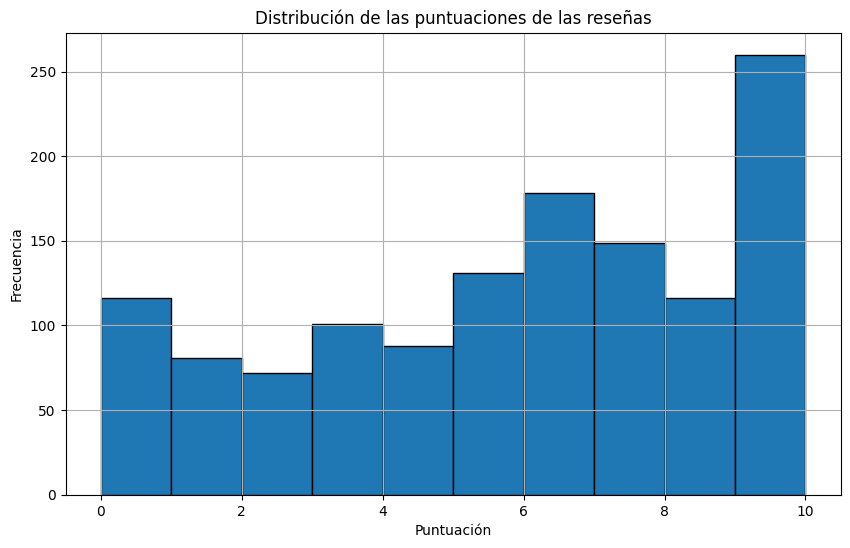

In [12]:
import matplotlib.pyplot as plt

# Asegúrate de que la columna 'score' esté en formato numérico
df['score'] = pd.to_numeric(df['score'], errors='coerce')

# Crear un histograma de los valores de la columna 'score' del DataFrame df
plt.figure(figsize=(10,6))
plt.hist(df['score'].dropna(), bins=10, edgecolor='black')  # Usar dropna() para eliminar valores nulos si los hay
plt.title('Distribución de las puntuaciones de las reseñas')
plt.xlabel('Puntuación')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()
